### 분류 실습 - 캐글 신용카드 사기 검출
- 0이 사기가 아닌 정상적인 데이터, 1은 신용카드 사기 트랜잭션
- 사기와 같은 이상 현상을 가진 데이터는 극도로 불균형한 분포를 가지기도 함

#### 언더 샘플링과 오버 샘플링의 이해
- 지도학습에서 극도로 불균형한 데이터 분포를 가지면 정상적인 데이터로 치우치게 학습해 이상 데이터의 검출이 어려울 수 있음
- 해결 방법 : 언더 샘플링, 오버 샘플링으로 적절한 학습 데이터를 확보
- **언더 샘플링** : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소 (정상 10000개, 비정상 100개 -> 정상 100개), 정상 데이터의 숫자가 작아져 제대로 된 학습이 어려울 수 있음.
- **오버 샘플링** : 이상 데이터처럼 적은 데이터 세트를 증식하여 충분한 데이터를 확보하는 방법. SMOTE, K 최근접 이웃 

#### 데이터 일차 가공 및 모델 학습/예측/평가
- 로지스틱 회귀와 LightGBM 기반 모델이 데이터 가공을 수행하며 예측 성능이 어떻게 변하는지 살펴보기
- 불균형한 데이터 분포를 가지므로 boost_from_average = False로 설정 (True로 설정 시 roc_auc 성능 저하)
- 재현율과 ROC_AUC가 로지스틱 회귀보다 높게 나타남

#### 데이터 분포도 변환 후 모델 학습/예측/평가
- 왜곡된 분포도를 가지는 데이터를 재가공한 후 모델 테스트
- standardscaler 변환 : 두 모델 모두 크게 개선되지는 않음.
- 로그 변환법(원래 값을 log 값으로 변환해 원래 큰 값을 작은 값으로 변환해 왜곡을 개선) : 정규분포 변환보다 약간 성능이 개선됨

#### 이상치 데이터 제거 후 모델 학습/예측/평가
- 이상치 : 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터
- IQR 방식을 주로 사용, box plot으로 시각화
- 이상치 데이터를 제거한 뒤 로지스틱 회귀와 lightgbm 모두 예측 성능이 크게 증가

#### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
- 로지스틱 회귀 모델의 경우 smote로 오버 샘플링된 데이터로 학습할 경우 재현율이 크게 증가햐지만 정밀도는 급격히 저하됨. 저조한 정밀도는 현실 업무에 적용 불가능
- 로지스틱 회귀모형에서는 올바른 예측 모델 생성 x

### 스태킹 앙상블
- 개별적인 여러 알고리즘을 결합해 예측 결과를 도출한다는 점에서 배깅, 부스팅과 공통되지만 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 점에서 있음 (메타 모델)
1. 개별적인 기반 모델
2. 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델
* 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것임.
* 캐글처럼 성능 수치를 조금이라도 높여야 할 경우 자주 사용됨

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [7]:
card_df.info()
# class 레이블만 int, 나머지 float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
from sklearn.model_selection import train_test_split
# 인자로 입력받은 DF를 복사한 뒤 Time만 삭제하고 복사된 df 반환
def get_preprocessed_df(df=None) :
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace = True)
    return df_copy

In [10]:
# 내부에서 train_test_split()을 호출, 테스트를 전체의 30%인 Stratified 방식으로 추출해 분포도를 동일하게 만듦
# 사전 데이터 가공 후 학습 / 테스트 데이터 세트 반환
def get_train_test_dataset(df=None) :
    # 인자로 입력된 df의 사전 데이터 가공이 완료된 복사 df 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:,-1]
    # train_test_split()으로 학습과 테스트 데이터 분할, stratify=y_target으로 Stratified 기반 분할
    X_train,X_test,y_train,y_test = train_test_split(
        X_features,y_target,test_size=0.3,random_state=0, 
        stratify = y_target
    )
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [19]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

# 약 17%로 잘 분할됨

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
def get_clf_eval(y_test, pred, pred_proba):
    # 오차 행렬, 정확도, 정밀도, 재현율, F1 스코어, ROC-AUC를 출력하는 함수
# 오차 행렬을 계산합니다. 
# 오차 행렬은 실제 레이블과 예측 레이블을 비교하여 True Positives, False Positives,
# True Negatives, False Negatives의 수를 표시합니다.
    confusion = confusion_matrix(y_test, pred)

# 정확도를 계산합니다.
# 정확도는 전체 데이터 중에서 올바르게 예측된 데이터의 비율입니다.
    accuracy = accuracy_score(y_test, pred)

# 정밀도를 계산합니다.
# 정밀도는 양성으로 예측된 데이터 중 실제로 양성인 데이터의 비율입니다.
    precision = precision_score(y_test, pred)

# 재현율을 계산합니다.
# 재현율(민감도)는 실제 양성 데이터 중 모델이 양성으로 예측한 데이터의 비율입니다.
    recall = recall_score(y_test, pred)

# F1 스코어를 계산합니다.
# F1 스코어는 정밀도와 재현율의 조화 평균이며, 두 지표의 균형을 나타냅니다.
    f1 = f1_score(y_test, pred)

# ROC-AUC 스코어를 계산합니다.
# ROC-AUC는 모델의 수신자 조작 특성 곡선(ROC) 아래의 면적을 측정하며,
# 1에 가까울수록 좋은 성능을 나타냅니다.
    roc_auc = roc_auc_score(y_test, pred_proba)

# 계산된 성능 지표들을 출력합니다.
    print('오차 행렬')
    print(confusion)
    print('\n정확도: {:.4f}, 정밀도: {:.4f}, 재현율: {:.4f}, F1: {:.4f}, ROC-AUC: {:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   58    90]]

정확도: 0.9992, 정밀도: 0.8824, 재현율: 0.6081, F1: 0.7200, ROC-AUC: 0.9609


In [30]:
def get_model_train_eval(model, ftr_train = None, ftr_test = None, 
                         tgt_train = None, tgt_test = None) :
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [31]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, 
                         n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, 
                    tgt_train=y_train,tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]

정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, ROC-AUC: 0.9797


In [ ]:
# 재현율과 ROC_AUC가 로지스틱 회귀보다 높게 나타남

<Axes: xlabel='Amount', ylabel='Density'>

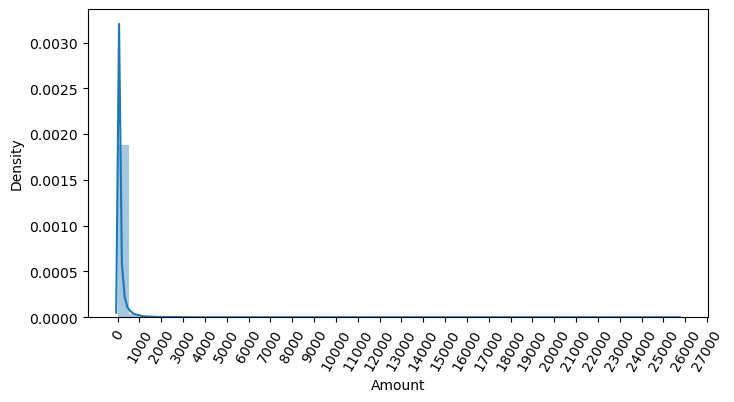

In [34]:
# 데이터 분포도 변환 후 모델 학습.예측.평가
import seaborn as sns
plt.figure(figsize = (8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.distplot(card_df['Amount'])

# amount(카드 사용금액) 1000불 이하인 데이터가 대부분이고 꼬리가 긴 형태의 곡선

In [36]:
# amount 피처를 정규분포로 변환
from sklearn.preprocessing import StandardScaler
# 정규분포 형태로 amount 피처값 변환
def get_preprocessed_df(df=None) :
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # 변환된 amount를 amount_scaled로 피처명 변경 후 DataFrame 멘앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, amount 삭제
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [38]:
# amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test,
                tgt_train=y_train, tgt_test = y_test)
print('### lightgbm 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, 
                         n_jobs = -1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, 
                    tgt_train=y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]

정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, ROC-AUC: 0.9702
### lightgbm 예측 성능 ###
오차 행렬
[[85135   160]
 [  128    20]]

정확도: 0.9966, 정밀도: 0.1111, 재현율: 0.1351, F1: 0.1220, ROC-AUC: 0.5697


In [39]:
# log 변환
def get_preprocessed_df(df=None) :
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace=True)
    return df_copy

In [40]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('#### 로지스틱 회귀 성능 예측 ####')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test,
                    tgt_train=y_train, tgt_test=y_test)
print('#### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train =X_train, ftr_test = X_test,
                    tgt_train=y_train, tgt_test=y_test)

#### 로지스틱 회귀 성능 예측 ####
오차 행렬
[[85283    12]
 [   59    89]]

정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, ROC-AUC: 0.9727
#### LightGBM 예측 성능 ###
오차 행렬
[[85122   173]
 [  144     4]]

정확도: 0.9963, 정밀도: 0.0226, 재현율: 0.0270, F1: 0.0246, ROC-AUC: 0.5123


<Axes: >

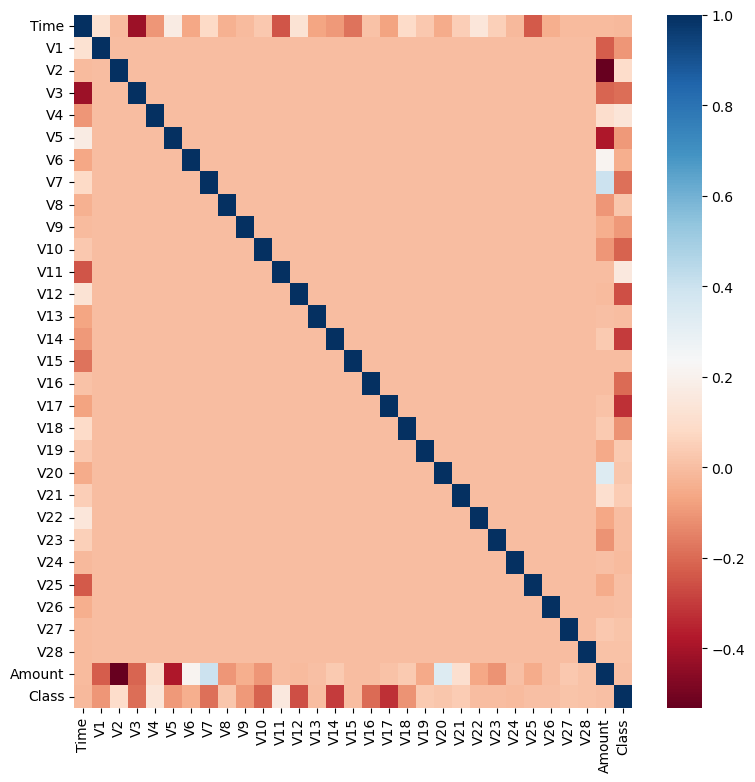

In [42]:
# 이상치 데이터 제거 후 모델 학습/예측/평가
import seaborn as sns
plt.figure(figsize = (9,9))
corr=card_df.corr()
sns.heatmap(corr, cmap='RdBu')
# 상관관계 히트맵 (양의 상관관계가 높을수록 진한 파란색에 가까움)

In [45]:
import numpy as np
def get_outlier(df=None, column=None, weight=1.5) :
    # fraud 에 해당하는 column 데이터만 추출, 1/4분위와 3/4 분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고 1.5를 곱해 최소/최대 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나 최솟값보다 작은 값을 이상치 데이터로 설정 후 DF인덱스 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [46]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스', outlier_index)

이상치 데이터 인덱스 Index([8296, 8615, 9035, 9252], dtype='int64')


In [50]:
# 이상치 추출 후 이를 삭제하는 로직 함수를 추가해 가공한 뒤 모델 재적용
# def_processed_df 로그 변환 후 v14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None) :
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace=True)
    # 이상치 데이터 삭제 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('###로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test,
                    tgt_train=y_train, tgt_test=y_test)
print('###lightgbm 예측 성능###')
get_model_train_eval(lgbm_clf, ftr_train=X_train,ftr_test = X_test, tgt_train=y_train, tgt_test=y_test)


###로지스틱 회귀 예측 성능###
오차 행렬
[[85281    14]
 [   48    98]]

정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, ROC-AUC: 0.9743
###lightgbm 예측 성능###
오차 행렬
[[85233    62]
 [   61    85]]

정확도: 0.9986, 정밀도: 0.5782, 재현율: 0.5822, F1: 0.5802, ROC-AUC: 0.7905


In [55]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
smote = SMOTE(random_state = 0)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
print('smote 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ',X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n', pd.Series(y_train_over).value_counts())
oversample = SMOTE()
# fit_sample 오류떠서 fit_resample 사용

smote 적용 전 학습용 피처/레이블 데이터 세트 :  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [57]:
lr_clf = LogisticRegression()
# ftr train tgt train 인지값이 smote 증식된 X_train_over, y_train_over 변경 유의
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test = X_test,
                    tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[82960  2335]
 [   12   134]]

정확도: 0.9725, 정밀도: 0.0543, 재현율: 0.9178, F1: 0.1025, ROC-AUC: 0.9737


In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

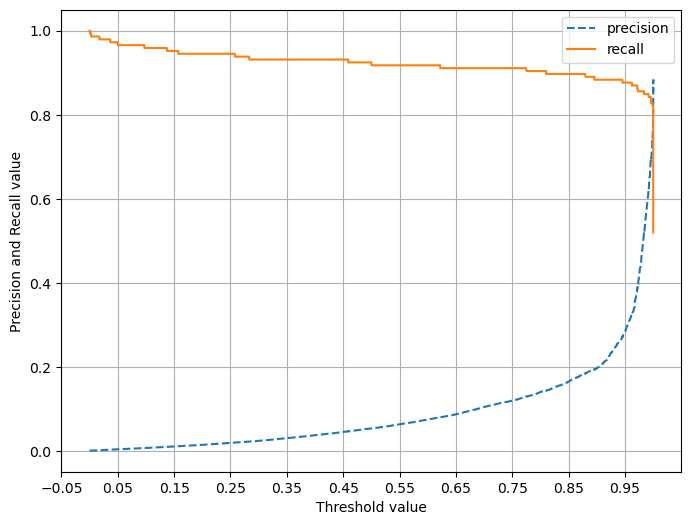

In [67]:
# 재현율 곡선을 통해 smote로 학습된 로지스틱 회귀 모델의 문제확인
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

# 임곗값 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대가 됨


In [70]:
lgbm_clf = LGBMClassifier(n_estimators = 500, num_leaves=64, 
                         n_jobs = -1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test = X_test,
                  tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[85288     7]
 [   22   124]]

정확도: 0.9997, 정밀도: 0.9466, 재현율: 0.8493, F1: 0.8953, ROC-AUC: 0.9852


기본 스태킹 모델

In [74]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                   y_label, test_size = 0.2,
                                                   random_state=0)

In [76]:
# 개별 ml 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors = 4)
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators = 100)

# 스태킹으로 만들어진 데이터를 학습,예측할 최종 모댈
lr_final = LogisticRegression(C=10)

In [79]:
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [82]:
# 학습된 개별 모델이 각자 변화하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

In [83]:
print('knn 정확도 : {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤포레스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

knn 정확도 : 0.9211
랜덤포레스트 정확도 : 0.9649
결정 트리 정확도 : 0.9123
에이다부스트 정확도 : 0.9561


In [84]:
pred=  np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행/열 위치 교환 , 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [87]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도 : 0.9649
